# Import modules

In [2]:
from google.colab import drive
drive.mount('/content/drive')
import sys
ROOT = "/content/drive/MyDrive/Colab Notebooks/TakeHomeProject"
sys.path.append(ROOT)

import torch
import torch.quantization
from torch.ao.quantization import QConfigMapping
from torch.ao.quantization import quantize_fx
from torch.ao.quantization.qconfig_mapping import get_default_qat_qconfig_mapping
import numpy as np
from torch import nn, optim
from torch.utils.data import Dataset
from torchvision import datasets, transforms

from PIL import Image
import matplotlib.pyplot as plt
import time
import copy

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

Mounted at /content/drive
cuda


# Global variables, data import / export path setting

In [27]:
BATCH_SIZE = 32
LR = 1e-3
EPOCH = 30
criterion = nn.CrossEntropyLoss() # Cross entropy loss at the end of fc layer
new_model_train = False # use existing parameters or not
model_type = "CNN"
dataset = "CIFAR10"
project_name = "KCML2_trial_2"

# data path, parameter or model path
CIFAR10_DS_PATH = f"{ROOT}/cifar-10-python/cifar-10-batches-py"
meta_file_path = f"{ROOT}/cifar-10-python/cifar-10-batches-py/batches.meta"

save_model_path = f"{ROOT}/results/fp32_models/{model_type}_{dataset}_{project_name}.pt"
save_model_path_overfit =f"{ROOT}/results/fp32_models/{model_type}_{dataset}_{project_name}_overfit.pt"
save_model_path_fp16 =f"{ROOT}/results/fp32_models/{model_type}_{dataset}_{project_name}_fp16.pt"

save_model_path_quantized_minmax = f"{ROOT}/results/quantized_models/{model_type}_{dataset}_{project_name}_quantminmax.pt"
save_model_path_quantized_histogram =f"{ROOT}/results/quantized_models/{model_type}_{dataset}_{project_name}_quanthistogram.pt"
save_model_path_quantized_fbgemm =f"{ROOT}/results/quantized_models/{model_type}_{dataset}_{project_name}_fbgemm.pt"

save_fig_path = f"{ROOT}/results/loss_plots/{model_type}_{dataset}_{project_name}.png"

# CIFAR 10 DATA importing

## 1. train = 10000 * 5
## 2. test = 10000 * 1
## 3. 3072 numpy array = (ch, x_pixel, y_pixel) = 3x32x32 color picture


In [4]:
import pickle
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# 1. merge train data (CIFAR10 - #of datas=  train: 10000*5set, test: 10000*1set)
train_data_list = []
train_labels_list = []

# 2. merge 5 training data
for i in range(1, 6):
    file_path = f"{CIFAR10_DS_PATH}/data_batch_{i}"
    batch_dict = unpickle(file_path)
    train_data_list.append(batch_dict[b'data']) # pixel data length 3072 = 3*32*32
    train_labels_list.extend(batch_dict[b'labels']) # lable data
train_data_array = np.concatenate(train_data_list, axis=0) # (10000, 3072) -> (50000, 3072)

# 3. label data -> numpy array
train_labels_array = np.array(train_labels_list)

# 4. load test data
file_path = f"{CIFAR10_DS_PATH}/test_batch"
batch_dict = unpickle(file_path)
test_data_array = np.array(batch_dict[b'data'])
test_labels_array = np.array(batch_dict[b'labels'])

In [5]:
# make custom Dataset class
# must define __init__, __len__, __getitem__

class Cifar10CustomDataset(Dataset):
    def __init__(self, data_array, labels_array, classes=None, transform=None, image_dtype=torch.float32):
        self.data = data_array   # (50000, 3072) numpy array, dtype=torch.uint8
        self.labels = labels_array # (50000,) numpy array, dtype=torch.int64
        self.transform = transform
        self.classes = classes
        self.image_dtype = image_dtype # for float16 mode

    def __len__(self):
        return len(self.labels) # 50000

    def __getitem__(self, idx):
        image_flat = self.data[idx] # get 3072 length flat color image
        label = self.labels[idx]

        # preprocessing: use torch.ToTransform()
        # ToTransform() have nice property:
        # 1. change normal pil image (H,W,C) to (C,H,W)
        # 2. convert image as torch.tensor
        # 3. convert [0,255]uint8 -> [0,1]float32 "uniform convert" -> may be changed
        # CIFAR10 already gives standard torch image format
        # image = image_flat.reshape(3, 32, 32) possible to use this one in CIFAR10 case

        image_chw = image_flat.reshape(3, 32, 32) # flat -> img
        image_hwc = image_chw.transpose(1, 2, 0) # change order in normal image
        image_pil = Image.fromarray(image_hwc)

        if self.transform:
            image = self.transform(image_pil) # ToTransform()

        if self.image_dtype == torch.float16: # addition: if we use GPU, we consider load as float16 dtype
            image = image.to(dtype=self.image_dtype)

        # problem: if we convert data on RAM not in VRAM, it may be much efficient to toss int8 data to GPU, not in this way
        # future design -> image_dtype = uint8 >> GPU >> convert

        return image, label

In [6]:
# lable information from metadata
meta_dict = unpickle(meta_file_path)
lable_names = meta_dict[b'label_names'] # list of which number matches to object


In [7]:
# define Dataset
transform = transforms.ToTensor()
train_DS = Cifar10CustomDataset(train_data_array, train_labels_array, classes=lable_names, transform=transform)
test_DS = Cifar10CustomDataset(test_data_array, test_labels_array, classes=lable_names, transform=transform)

# float16 data processing
test_DS_fp16 = Cifar10CustomDataset(test_data_array, test_labels_array, classes=lable_names, transform=transform, image_dtype=torch.float16)

# split training data -> Train, validation data, quantization
# val_= to decide when to stop training / check best validation loss
# quant_ = for static quantization
total_size = len(train_DS)
val_size = int(total_size * 0.05) # 5% of train data
quant_size = int(total_size * 0.05) # 5% of train data
train_size = total_size - val_size - quant_size
train_DS, val_DS, quant_DS = torch.utils.data.random_split(train_DS, [train_size, val_size, quant_size])


# dataset object -> dataloader object
train_DL = torch.utils.data.DataLoader(train_DS, batch_size=BATCH_SIZE, shuffle=True)
val_DL = torch.utils.data.DataLoader(val_DS, batch_size=BATCH_SIZE, shuffle=False)
quant_DL = torch.utils.data.DataLoader(quant_DS, batch_size=BATCH_SIZE, shuffle=True)
test_DL = torch.utils.data.DataLoader(test_DS, batch_size=BATCH_SIZE, shuffle=True)
test_DL_fp16 = torch.utils.data.DataLoader(test_DS_fp16, batch_size=BATCH_SIZE, shuffle=True)

In [8]:
xl, yl = next(iter(test_DL_fp16))
print(xl.shape)
print(xl.dtype)
print(yl.dtype)

torch.Size([32, 3, 32, 32])
torch.float16
torch.int64


# pick one CIFAR10 example data

1. metadat keys: dict_keys([b'num_cases_per_batch', b'label_names', b'num_vis'])

2. label names: [b'airplane', b'automobile', b'bird', b'cat', b'deer', b'dog', b'frog', b'horse', b'ship', b'truck']

3. label ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

4. each label {'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}에 배정

5. torch.tensor type, torch.Size([32, 3, 32, 32])
, x_batch has 32(BATCH_SIZE) datas, 3 ch, 32x32 picture

6. y_batch has 32 length torch.uint64 label, torch.Size([32])

7. one pixel of x batch -> float 32 and [0,1] range

## Dataset info

Train data = 45000

validation data = 2500

quantization opt data = 2500

Test data = 10000



# CNN model structure

1. conv -> BN -> ReLU = one layer

2. each block has 3 conv layer

3. after each block -> MaxPool2d(2) for half image size

4. total 3 block and 3 pooling -> FC layer -> decide 10 node

5. Loss function = CE Loss (nice choice for

In [9]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv_block1 = nn.Sequential(nn.Conv2d(3,32,3, stride=1, padding=1),
                                         nn.BatchNorm2d(32),
                                         nn.ReLU(),
                                         nn.Conv2d(32,32,3, stride=1, padding=1),
                                         nn.BatchNorm2d(32),
                                         nn.ReLU(),
                                         nn.Conv2d(32,32,3, stride=1, padding=1),
                                         nn.BatchNorm2d(32),
                                         nn.ReLU())
        self.Maxpool1 = nn.MaxPool2d(2)

        self.conv_block2 = nn.Sequential(nn.Conv2d(32,64,3, stride=1, padding=1),
                                          nn.BatchNorm2d(64),
                                          nn.ReLU(),
                                          nn.Conv2d(64,64,3, stride=1, padding=1),
                                          nn.BatchNorm2d(64),
                                          nn.ReLU(),
                                          nn.Conv2d(64,64,3, stride=1, padding=1),
                                          nn.BatchNorm2d(64),
                                          nn.ReLU())
        self.Maxpool2 = nn.MaxPool2d(2)

        self.conv_block3 = nn.Sequential(nn.Conv2d(64,128,3, stride=1, padding=1),
                                          nn.BatchNorm2d(128),
                                          nn.ReLU(),
                                          nn.Conv2d(128,128,3, stride=1, padding=1),
                                          nn.BatchNorm2d(128),
                                          nn.ReLU(),
                                          nn.Conv2d(128,128,3, stride=1, padding=1),
                                          nn.BatchNorm2d(128),
                                          nn.ReLU())
        self.Maxpool3 = nn.MaxPool2d(2)

        self.fc = nn.Sequential(nn.Linear(128*4*4,512),
                                nn.Linear(512,10))

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.Maxpool1(x)
        x = self.conv_block2(x)
        x = self.Maxpool3(x)
        x = self.conv_block3(x)
        x = self.Maxpool3(x)
        x = torch.flatten(x, start_dim=1) # 32x128x4x4data flatten start dim=1: maintain data, only flatten C,W,H
        x = self.fc(x)

        return x

# Check data size after conv blocks

1. conv calcuation doesn't change size of picture. only maxpoool changes. so the picture size is 32x32 >> 16x16 >> 8x8 >> 4x4

2. final flatten layer node has 128(channel) * 4 * 4 nodes. So, torch.Size([32,2048]) >> torch.Size([32,10])

# Model Train / Test function

In [10]:
def Train(model, train_DL, val_DL, criterion, optimizer, EPOCH, save_model_path):

    train_loss_history =[]
    val_loss_history = []
    NoT = len(train_DL.dataset)
    NoV = len(val_DL.dataset) # Number of element in dataset
    best_model_weights = None # keep the best loss score model
    best_val_loss = float('inf') # check validation data loss
    best_epoch = 0

    for ep in range(EPOCH):
        model.train() # train mode
        rloss = 0 # running loss
        for x_batch, y_batch in train_DL:
            x_batch = x_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE)
            # inference
            y_hat = model(x_batch)
            # loss
            loss = criterion(y_hat, y_batch)
            # update
            optimizer.zero_grad() # initialize gradient
            loss.backward() # backpropagation
            optimizer.step() # weight update
            # loss accumulation
            loss_b = loss.item() * x_batch.shape[0] # batch loss - count for last batch size != 32
            rloss += loss_b # running loss
        # print loss
        loss_e = rloss/NoT
        train_loss_history += [loss_e]
        print(f"Epoch: {ep+1}, train loss: {round(loss_e,3)}")

        # validation loss
        model.eval() # eval mode
        with torch.no_grad():
            rloss = 0
            for x_batch, y_batch in val_DL:
                x_batch = x_batch.to(DEVICE)
                y_batch = y_batch.to(DEVICE)
                # inference
                y_hat = model(x_batch) # 32 x 10
                loss_val = criterion(y_hat, y_batch)
                loss_b = loss_val.item() * x_batch.shape[0]
                rloss += loss_b
            loss_ev = rloss / NoV
            val_loss_history += [loss_ev]
        print(f"Epoch: {ep+1}, validation loss: {round(loss_ev,3)}")

        # model checkpoint: if that epoch shows lowest loss, record that weight
        if loss_ev < best_val_loss:
            best_val_loss = loss_ev
            best_epoch = ep+1

            torch.save(model.state_dict(), save_model_path)
            print(f"(New best model saved with val_loss: {best_val_loss:.3f})")
        print("-"*20)
    torch.save(model.state_dict(), save_model_path_overfit) # also save overfitted model
    return train_loss_history, val_loss_history, best_epoch

def Test(model, test_DL, device='cpu'): # default cpu
    test_model = model.eval()
    NoT = len(test_DL.dataset)
    # model_dtype = next(model.parameters()).dtype
    with torch.no_grad():
        rcorrect = 0
        rloss = 0
        for x_batch, y_batch in test_DL:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            # x_batch = x_batch.to(dtype=model_dtype)
            # inference
            y_hat = model(x_batch)
            # loss accumulation
            loss_val = criterion(y_hat, y_batch)
            loss_b = loss_val.item() * x_batch.shape[0]
            rloss += loss_b
            # accuracy accumulation
            pred = y_hat.argmax(dim=1) # argmax for 10 class
            corrects_b = torch.sum(pred == y_batch).item() # return #of correct
            rcorrect += corrects_b
        accuracy_e = rcorrect/len(test_DL.dataset)*100
        loss_e = rloss / NoT
    print(f"Test accuracy: {rcorrect}/{len(test_DL.dataset)} ({round(accuracy_e,1)} %)")
    print(f"Test loss: {round(loss_e,3)}")

# test result ploting function

In [11]:
def Test_plot(model, test_DL, lable_names):

    model.eval()
    with torch.no_grad():
        x_batch, y_batch = next(iter(test_DL))
        x_batch = x_batch.to(DEVICE)
        y_hat = model(x_batch)
        pred = y_hat.argmax(dim=1)

    x_batch = x_batch.to("cpu")

    plt.figure(figsize=(8,4))
    for idx in range(6):
        plt.subplot(2,3, idx+1, xticks=[], yticks=[])
        plt.imshow(x_batch[idx].permute(1,2,0).squeeze(), cmap="gray")
        pred_class = lable_names[pred[idx]]
        true_class = lable_names[y_batch[idx]]
        plt.title(f"{pred_class} ({true_class})", color = "g" if pred_class==true_class else "r")

def count_params(model, count_all_parameters=False):
    if count_all_parameters: # count all paras
        num = sum([p.numel() for p in model.parameters()])
    else:  # it doesn't work for int8 quantized model..
        num = sum([p.numel() for p in model.parameters() if p.requires_grad])

    return num

# Training excute part

In [13]:
########
# before excute change the global variable - save_model_path
########
if new_model_train:
    # 1. initialize model
    exec(f"model = {model_type}().to(DEVICE)")

    # 2. use adam
    optimizer = optim.Adam(model.parameters(), lr=LR)

    # 3. start training
    train_loss_history, val_loss_history, best_epoch = Train(model, train_DL, val_DL, criterion, optimizer, EPOCH, save_model_path)

    # 4. plot
    best_val_loss = min(val_loss_history)
    plt.plot(range(1,EPOCH+1),train_loss_history, label="Train loss")
    plt.plot(range(1,EPOCH+1),val_loss_history, label="Validation loss")
    plt.scatter(best_epoch, best_val_loss,
                color='red',
                label=f'Best Epoch ({best_epoch})', # label
                zorder=5)
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.title(f"Train Loss vs Validation Loss {project_name}")
    plt.legend()
    plt.grid()
    plt.savefig(save_fig_path)

# Test result checking

In [16]:
# load parameter and check it is well loaded
model_for_test = CNN().to(DEVICE)
weights_dict = torch.load(save_model_path, map_location=DEVICE)
model_for_test.load_state_dict(weights_dict)

ovmodel_for_test = CNN().to(DEVICE)
weights_dict = torch.load(save_model_path_overfit, map_location=DEVICE)
ovmodel_for_test.load_state_dict(weights_dict)

# model_for_test = CNN().to('cpu')
# weights_dict = torch.load(save_model_path, map_location='cpu')
# model_for_test.load_state_dict(weights_dict)

<All keys matched successfully>

In [ ]:
start = time.time()
Test(model_for_test, test_DL, device=DEVICE) # DEVICE variable - cpu or cuda
Test(ovmodel_for_test, test_DL, device=DEVICE)
print(count_params(model_for_test))
end = time.time()
print(f"총 걸린 시간: {(end - start)}초")
# Test accuracy: 2022/2500 (80.9 %)
# Test accuracy: 2098/2500 (83.9 %)
# 1536330
# 총 걸린 시간: 1.391693353652954초
# loss function - account for how much the model confidently answer that label
# CE loss greatly penalize for wrong answer as well as correct answer with low confidence

Test accuracy: 8282/10000 (82.8 %)
Test loss: 0.552
Test accuracy: 8353/10000 (83.5 %)
Test loss: 1.001
1536330
총 걸린 시간: 3.9703922271728516초


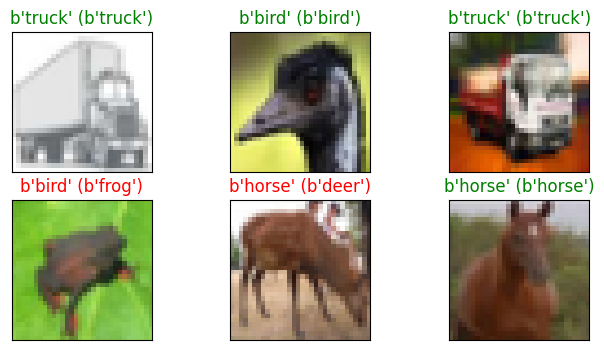

In [ ]:
Test_plot(model_for_test, val_DL, lable_names)

# quantization code

In [ ]:
# --- 1. load original model fp32 ---
# quantization is done only on cpu
model_fp32 = CNN().to('cpu')
weights_dict = torch.load(save_model_path, map_location='cpu')
model_fp32.load_state_dict(weights_dict)
model_fp32.eval() # dont forget evaluation mode

print("--- 원본 FP32 모델 준비 완료 ---")
# print(model_fp32)

--- 원본 FP32 모델 준비 완료 ---


In [ ]:
# --- 2. setting quantization profile (FX Graph Mode) ---
# three type of quantization option
# 1. activation observer: MinMax / weight observer per_channel
# 2. activation observer: histogram / weight observer per_channel
# 3. qconfig "fbgemm"

# 1.1 Activation observer set
act_observer_minmax = torch.quantization.MinMaxObserver.with_args(
    dtype=torch.quint8, # uint8, for ReLU activation function
    qscheme=torch.per_tensor_affine,
    reduce_range=True # old cpu
)

# 1.2 weight observer : Per-Channel
weight_observer = torch.quantization.PerChannelMinMaxObserver.with_args(
    dtype=torch.qint8, # allow minus
    qscheme=torch.per_channel_symmetric
)

# 2. second quantization scheme
act_observer_histogram = torch.quantization.HistogramObserver.with_args( # MinMax -> Histogram
    dtype=torch.quint8,
    qscheme=torch.per_tensor_affine,
    reduce_range=True
)

# qconfig making
# type 1
qconfig_minmax = torch.quantization.QConfig(
    activation=act_observer_minmax,
    weight=weight_observer
)

# type 2
qconfig_histogram = torch.quantization.QConfig(
    activation=act_observer_histogram,
    weight=weight_observer
)
# type 3
qconfig_fbgemm = torch.ao.quantization.get_default_qconfig('fbgemm')


# Further study -> can we give different quantization setting to each layer and each weight? not global?
qconfig_mapping_minmax = torch.ao.quantization.QConfigMapping().set_global(qconfig_minmax)
qconfig_mapping_histogram = torch.ao.quantization.QConfigMapping().set_global(qconfig_histogram)
qconfig_mapping_fbgemm = torch.ao.quantization.QConfigMapping().set_global(qconfig_fbgemm)

# FX Graph Mode = requires one trace of model
# pick one batch from val_DL
example_inputs, _ = next(iter(val_DL))
print("qconfig mapping ready")

qconfig mapping 준비 완료


In [ ]:
# 3. (Prepare) model prepare:
# insert observer for place needs quantization
model_prepared_minmax = torch.ao.quantization.quantize_fx.prepare_fx(
    model_fp32, qconfig_mapping_minmax, example_inputs
)
model_prepared_histogram = torch.ao.quantization.quantize_fx.prepare_fx(
    model_fp32, qconfig_mapping_histogram, example_inputs
)
model_prepared_fbgemm = torch.ao.quantization.quantize_fx.prepare_fx(
    model_fp32, qconfig_mapping_fbgemm, example_inputs
)
print("\n--- FX Graph Mode로 모델 준비 완료 ---")

/tmp/ipython-input-3904692965.py:5: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  model_prepared_minmax = torch.ao.quantization.quantize_fx.prepare_fx(
/usr/local/lib/python3.12/dist-packages/torch/ao/quantization/observer.py:246: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a f


--- FX Graph Mode로 모델 준비 완료 ---


In [ ]:
# --- 4. Calibration ---
# Observer pass through the model
# Obsever records minmax or needed parameter for quantization
print("--- Calibration start... ---")
with torch.no_grad():
    for x_batch, y_batch in val_DL:
        model_prepared_minmax(x_batch)
        model_prepared_histogram(x_batch)
        model_prepared_fbgemm(x_batch)
print("--- 보정 완료 ---")

--- 보정(Calibration) 시작... ---
--- 보정 완료 ---


In [ ]:
# --- 5. Conversion ---
# with recorded min/max or conversion information -> convert to int8
# This function delete observer
model_quantized_minmax = torch.ao.quantization.quantize_fx.convert_fx(model_prepared_minmax)
model_quantized_histogram = torch.ao.quantization.quantize_fx.convert_fx(model_prepared_histogram)
model_quantized_fbgemm = torch.ao.quantization.quantize_fx.convert_fx(model_prepared_fbgemm)
print("\n--- FX Graph Mode로 INT8 변환 완료 ---")
# print(model_quantized)

/tmp/ipython-input-2242817714.py:4: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  model_quantized_minmax = torch.ao.quantization.quantize_fx.convert_fx(model_prepared_minmax)
/tmp/ipython-input-2242817714.py:5: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.


--- FX Graph Mode로 INT8 변환 완료 ---


# quantized model save

In [ ]:
# 1. TorchScript transform (JIT Trace)
#    to fix model structure - pick one data
example_input = next(iter(val_DL))[0].to('cpu')
traced_model = torch.jit.trace(model_quantized_minmax, example_input) # pass 1 time
torch.jit.save(traced_model, save_model_path_quantized_minmax)
print(f"minmax모델이 TorchScript 형식으로 저장되었습니다")

example_input = next(iter(val_DL))[0].to('cpu')
traced_model = torch.jit.trace(model_quantized_histogram, example_input) # pass 1 time
torch.jit.save(traced_model, save_model_path_quantized_histogram)
print(f"histogram모델이 TorchScript 형식으로 저장되었습니다")

traced_model = torch.jit.trace(model_quantized_fbgemm, example_input) # pass 1 time
torch.jit.save(traced_model, save_model_path_quantized_fbgemm)
print(f"fbgemm모델이 TorchScript 형식으로 저장되었습니다")

minmax모델이 TorchScript 형식으로 저장되었습니다
minmax모델이 TorchScript 형식으로 저장되었습니다
fbgemm모델이 TorchScript 형식으로 저장되었습니다


# Evaluate  quantized model

In [ ]:
# --- load ---
loaded_quantized_model_minmax = torch.jit.load(save_model_path_quantized_minmax)
loaded_quantized_model_histogram = torch.jit.load(save_model_path_quantized_histogram)
loaded_quantized_model_fbgemm = torch.jit.load(save_model_path_quantized_fbgemm)

# 32bit model
model_fp32 = CNN().to('cpu')
weights_dict = torch.load(save_model_path, map_location='cpu')
model_fp32.load_state_dict(weights_dict)
model_fp32.eval()

# 32bit model_overfitted
model_fp32_overfit = CNN().to('cpu')
weights_dict_overfit = torch.load(save_model_path_overfit, map_location='cpu')
model_fp32_overfit.load_state_dict(weights_dict_overfit)
model_fp32_overfit.eval()

# 16bit model ### only for gpu
model_fp16 = copy.deepcopy(model_fp32).half().to('cpu')
model_fp16.eval()
print("model loaded successfully")

모델 로드 완료!


In [ ]:
# make dict for model name and model
models_dict = {
    "model_fp32": model_fp32,
    # "model_fp16": model_fp16,
    "model_fp32_overfit": model_fp32_overfit,
    "quantized_minmax": loaded_quantized_model_minmax,
    "quantized_fbgemm": loaded_quantized_model_fbgemm,
    "quantized_histogram": loaded_quantized_model_histogram,
}

for name, model in models_dict.items():
    start = time.time()
    # if name == 'model_fp16':
    #     Test(model, test_DL_fp16, device='cpu') # fp16 only for gpu cpu does not offer fp116 calc
    else:
        Test(model, test_DL, device='cpu')
    end = time.time()
    print(f"{name} Total time: {(end - start)}sec")


Test accuracy: 8282/10000 (82.8 %)
Test loss: 0.552
model_fp32 총 걸린 시간: 27.03730869293213초
Test accuracy: 8353/10000 (83.5 %)
Test loss: 1.001
model_fp32_overfit 총 걸린 시간: 27.0750629901886초
Test accuracy: 8249/10000 (82.5 %)
Test loss: 0.558
quantized_minmax 총 걸린 시간: 17.768279314041138초
Test accuracy: 8254/10000 (82.5 %)
Test loss: 0.554
quantized_fbgemm 총 걸린 시간: 18.057853937149048초
Test accuracy: 8254/10000 (82.5 %)
Test loss: 0.554
quantized_histogram 총 걸린 시간: 17.286684274673462초


# function for fp16 model testing

In [17]:
def Test_FP16(model, test_DL, device='cpu'):
    with torch.no_grad():
        rcorrect = 0
        for x_batch, y_batch in test_DL:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            y_hat = model(x_batch)
            pred = y_hat.argmax(dim=1)
            corrects_b = torch.sum(pred == y_batch).item()
            rcorrect += corrects_b
        accuracy_e = rcorrect/len(test_DL.dataset)*100
    print(f"Test accuracy: {rcorrect}/{len(test_DL.dataset)} ({round(accuracy_e,1)} %)")


# 32 bit model vs 16 bit model

In [28]:
test_model_fp32 = CNN().to(DEVICE)
weights_dict = torch.load(save_model_path, map_location=DEVICE)
test_model_fp32.load_state_dict(weights_dict)
test_model_fp32.eval()

print("\n--- GPU FP32 time start ---")
torch.cuda.synchronize() # GPU time sync
start = time.time()

Test(test_model_fp32, test_DL, device=DEVICE)

torch.cuda.synchronize()
end = time.time()
print(f"FP32 Time (GPU): {end - start} sec")


--- GPU FP32 속도 측정 시작 ---
Test accuracy: 8282/10000 (82.8 %)
Test loss: 0.552
FP16 Time (GPU): 2.1899988651275635 sec


In [30]:
# 1. change model to fp16 base and move to GPU
test_model_fp16 = copy.deepcopy(test_model_fp32).half().to(DEVICE)
test_model_fp16.eval()

print("\n--- GPU FP16 time start ---")

torch.cuda.synchronize()
start = time.time()

Test(test_model_fp16, test_DL_fp16, device=DEVICE)

torch.cuda.synchronize()
end = time.time()
print(f"FP16 Time (GPU): {end - start} sec")


--- GPU FP16 속도 측정 시작 ---
Test accuracy: 8280/10000 (82.8 %)
Test loss: 0.552
FP16 Time (GPU): 2.259366035461426 sec


In [31]:
torch.save(test_model_fp16.state_dict(), save_model_path_fp16)